In [771]:
import mne 
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
figure(figsize=(1,1))
from mne.decoding import UnsupervisedSpatialFilter
from sklearn.decomposition import PCA, FastICA
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
from mne.decoding import Vectorizer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import classification_report
import itertools
from sklearn.svm import SVC 

from mne.preprocessing import ICA


In [772]:
setFile = '/Volumes/flash32/EEGLAB/SA20140306/20140306_1133.set'

In [773]:
raw = mne.io.read_raw_eeglab(setFile,preload = True)

Reading /Volumes/flash32/EEGLAB/SA20140306/20140306_1133.fdt
Reading 0 ... 951345  =      0.000 ...  1858.096 secs...


In [433]:
raw.info

<Info | 17 non-empty fields
    bads : list | 0 items
    buffer_size_sec : float | 1.0
    ch_names : list | Lm, LE1, Nasium, LE3, LD2, LD5, LC3, LC6, LB1, ...
    chs : list | 129 items (EEG: 128, STIM: 1)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : Transform | 3 items
    dig : list | 128 items
    events : list | 0 items
    highpass : float | 0.0 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    lowpass : float | 256.0 Hz
    nchan : int | 129
    proc_history : list | 0 items
    projs : list | 0 items
    sfreq : float | 512.0 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    experimenter : NoneType
    file_id : NoneType
    gantry_angle : NoneType
    hpi_subsystem : NoneType
    kit_system_id : NoneType
    line_freq : NoneType
    meas_date : NoneType
    meas_id : NoneType
    proj_id : NoneType
    proj_name : NoneType
    subject_inf

In [774]:
def find_events(raw):
    return mne.find_events(raw,output='offset',min_duration=1/raw.info['sfreq'],shortest_event=0.5)

In [775]:
events = find_events(raw)
events

5792 events found
Event IDs: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  31 129 130 131 132 133 134 135 136 137 138 139
 140 141 142 143 144 145 155 156 157 158 159 160 161 162 163 164 165]


array([[  6715,      0,    131],
       [  7046,      0,     31],
       [  7049,      0,    137],
       ...,
       [841233,      0,      4],
       [841501,      0,    134],
       [841503,      0,    129]])

In [776]:
def get_trials(events):
    trials = []
    current_trial = []
    for event in events:
        if event[-1] == 31 and current_trial != []:
            trials.append(current_trial)
            current_trial = []
            current_trial.append(event)
        else:
            current_trial.append(event)
    trials.append(current_trial)
    return trials

In [777]:
trials = get_trials(events)

In [778]:
"""
filter out all trials that are not within stim code definitions.
The second flanker stim code should be one plus the first flanker stim code. 
"""

def filter_trials(trials):
    events = find_events(raw)
    trials = get_trials(events)
    filteredTrials = []
    for trial in trials:
        first_stim = False
        third_stim = False
        first_stim_code = 0
        
        for event in trial:
            if first_stim == True and third_stim == True:
                filteredTrials.append(trial)
                first_stim = False
                third_stim = False
                break;
            else:    
                #print(event[-1])
                if event[-1] <= 24 and first_stim == False:
                        first_stim_code = event[-1]
                        first_stim = True
                elif event[-1] <=24 and first_stim == True:    
                    if event[-1] + 1 == first_stim_code:
                        third_stim = True
                        first_stim_code = 0

    return np.concatenate(filteredTrials,axis = 0)

In [779]:
#trials
filter_trials(trials)

5792 events found
Event IDs: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  31 129 130 131 132 133 134 135 136 137 138 139
 140 141 142 143 144 145 155 156 157 158 159 160 161 162 163 164 165]


array([[  7046,      0,     31],
       [  7049,      0,    137],
       [  7052,      0,    164],
       ...,
       [841233,      0,      4],
       [841501,      0,    134],
       [841503,      0,    129]])

In [780]:
def get_events_with_stim_code(events):
    """
    Return only events with stim codes from all the events
    make sure to make numpy arrays all events and return final array numpy
    """
    stim_events = []
    for event in events:
        if event[-1] <=24:
            stim_events.append(np.array(event))
    return np.array(stim_events)        
    

In [781]:
events

array([[  6715,      0,    131],
       [  7046,      0,     31],
       [  7049,      0,    137],
       ...,
       [841233,      0,      4],
       [841501,      0,    134],
       [841503,      0,    129]])

In [782]:
get_events_with_stim_code(events)

array([[  7064,      0,      2],
       [  7314,      0,      6],
       [  7564,      0,      1],
       ...,
       [840706,      0,      5],
       [840965,      0,      3],
       [841233,      0,      4]])

In [783]:
def get_stim_code_event_ids(events, event_ids):
    """
    Description:
        return dictionay of event_ids that match the criteria of the eeglab file.
        Some files may not have all stim-code events, and to avoid errors when creating epochs, 
        this method will return a dictionary of compatible event_ids.
        
    Variables:
        events: ndarray of ints (n_events, 3)
        event_ids: dictionary of event_ids 
            ex. {'stim-code': 1}
    -----
    return: dictionary of event_ids
    """
    unique_events = np.unique(events[:,-1])
    event_id_values = event_ids.values()
    event_dict = {}
    
    for event_id in unique_events:
        if event_id in event_id_values:
            key = list(event_ids.keys())[event_id-1]
            event_dict[key] = event_id
            
    return event_dict

In [784]:
events = filter_trials(trials)
stim_code_events = get_events_with_stim_code(events)
get_stim_code_event_ids(stim_code_events,new_stim_code_event_ids)

5792 events found
Event IDs: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  31 129 130 131 132 133 134 135 136 137 138 139
 140 141 142 143 144 145 155 156 157 158 159 160 161 162 163 164 165]


{'b-f1-pic': 8,
 'b-f1-snd': 11,
 'b-f1-spk': 5,
 'b-f1-wrd': 2,
 'b-f2-pic': 7,
 'b-f2-snd': 10,
 'b-f2-spk': 4,
 'b-f2-wrd': 1,
 'b-tg-pic': 9,
 'b-tg-snd': 12,
 'b-tg-spk': 6,
 'b-tg-wrd': 3,
 'f-f1-pic': 20,
 'f-f1-snd': 23,
 'f-f1-spk': 17,
 'f-f1-wrd': 14,
 'f-f2-pic': 19,
 'f-f2-snd': 22,
 'f-f2-spk': 16,
 'f-f2-wrd': 13,
 'f-tg-pic': 21,
 'f-tg-snd': 24,
 'f-tg-spk': 18,
 'f-tg-wrd': 15}

In [785]:
new_stim_code_event_ids

{'b-f1-pic': 8,
 'b-f1-snd': 11,
 'b-f1-spk': 5,
 'b-f1-wrd': 2,
 'b-f2-pic': 7,
 'b-f2-snd': 10,
 'b-f2-spk': 4,
 'b-f2-wrd': 1,
 'b-tg-pic': 9,
 'b-tg-snd': 12,
 'b-tg-spk': 6,
 'b-tg-wrd': 3,
 'f-f1-pic': 20,
 'f-f1-snd': 23,
 'f-f1-spk': 17,
 'f-f1-wrd': 14,
 'f-f2-pic': 19,
 'f-f2-snd': 22,
 'f-f2-spk': 16,
 'f-f2-wrd': 13,
 'f-tg-pic': 21,
 'f-tg-snd': 24,
 'f-tg-spk': 18,
 'f-tg-wrd': 15}

In [786]:
def artifact_removal(eeglab):
    """
    NOTE: use this method after creating epoch objects to speed up process!
    
    Description:
        Perform notch filter, frequenc filter, and ICA 
        
    Variables: 
        eeglab: mne.io.eeglab.eeglab.RawEEGLAB object
    returns:
        eeglab: mne.io.eeglab.eeglab.RawEEGLAB object

    """
    
    raw.notch_filter(np.arange(60,241,60), filter_length='auto', phase = 'zero')
    raw.filter(5,100, fir_design='firwin')
    raw.resample(256, n_jobs=10)
    ica = ICA(n_components=None, max_iter = 1000, random_state = 42)
    ica.fit(raw,picks = None, decim=3, reject=dict(mag=4e-12, grad=4000e-13))
    ica.detect_artifacts(raw,start_find=None, stop_find=None, ecg_ch=None, 
                 ecg_score_func='pearsonr', skew_criterion=None, 
                 kurt_criterion=None, var_criterion=None,add_nodes=None)
    
    return ica.apply(raw)
    

In [787]:
new_stim_code_event_ids = {
     
    "b-f2-wrd":1,
    "b-f1-wrd":2,
    "b-tg-wrd":3,

    "b-f2-spk":4,
    "b-f1-spk":5,
    "b-tg-spk":6,

    "b-f2-pic":7,
    "b-f1-pic":8,
    "b-tg-pic":9,

    "b-f2-snd":10,
    "b-f1-snd":11,
    "b-tg-snd":12,

    "f-f2-wrd":13,
    "f-f1-wrd":14,
    "f-tg-wrd":15,

    "f-f2-spk":16,
    "f-f1-spk":17,
    "f-tg-spk":18,

    "f-f2-pic":19,
    "f-f1-pic":20,
    "f-tg-pic":21,

    "f-f2-snd":22,
    "f-f1-snd":23,
    "f-tg-snd":24
}

In [788]:
def create_epochs(raw,events,event_id,):
    tmax = (1/raw.info['sfreq']) * 499  #to get desired epoch length
    return mne.Epochs(raw=raw,events=events,event_id=event_id,tmin=0,tmax=tmax,preload=True )

In [789]:
def remove_artifacts_and_create_epochs(raw):
    events = filter_trials(trials)
    stim_code_events = get_events_with_stim_code(events)
    stim_code_event_ids = get_stim_code_event_ids(stim_code_events,new_stim_code_event_ids)
    raw_ica = artifact_removal(raw)
    
    return create_epochs(raw_ica,events,new_stim_code_event_ids)

In [790]:
epoch = remove_artifacts_and_create_epochs(raw)

5792 events found
Event IDs: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  31 129 130 131 132 133 134 135 136 137 138 139
 140 141 142 143 144 145 155 156 157 158 159 160 161 162 163 164 165]
Setting up band-stop filter
Filter length of 3379 samples (6.600 sec) selected
Setting up band-pass filter from 5 - 1e+02 Hz
l_trans_bandwidth chosen to be 2.0 Hz
h_trans_bandwidth chosen to be 25.0 Hz
Filter length of 845 samples (1.650 sec) selected
5792 events found
Event IDs: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  31 129 130 131 132 133 134 135 136 137 138 139
 140 141 142 143 144 145 155 156 157 158 159 160 161 162 163 164 165]


[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   36.4s
[Parallel(n_jobs=10)]: Done 129 out of 129 | elapsed:  1.9min finished


5388 events found
Event IDs: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  31 129 130 131 132 133 134 135 136 137 138 139
 140 141 142 143 144 145 155 156 157 158 159 160 161 162 163 164 165]
Fitting ICA to data using 128 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 128
Fitting ICA took 336.7s.
    Searching for artifacts...
Artifact indices found:
    
Ready.
Transforming to ICA space (128 components)
Zeroing out 0 ICA components
1920 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 1920 events and 500 original time points ...
936 bad epochs dropped


In [791]:
epoch

<Epochs  |   984 events (all good), 0 - 1.94922 sec, baseline [None, 0], ~484.6 MB, data loaded,
 'b-f1-pic': 80
 'b-f1-snd': 40
 'b-f1-spk': 20
 'b-f1-wrd': 60
 'b-f2-pic': 80
 'b-f2-snd': 40
 'b-f2-spk': 20
 'b-f2-wrd': 60
 'b-tg-pic': 80
 'b-tg-snd': 40
 'b-tg-spk': 40
 'b-tg-wrd': 40
 'f-f1-pic': 60
 'f-f1-snd': 28
 'f-f1-spk': 40
 'f-f1-wrd': 0
 'f-f2-pic': 60
 'f-f2-snd': 28
 'f-f2-spk': 40
 'f-f2-wrd': 0
 'f-tg-pic': 0
 'f-tg-snd': 80
 'f-tg-spk': 8
 'f-tg-wrd': 40>

In [792]:
epoch.events.shape[0]

984

In [793]:
stim_combinations = {
    (5,6,4): "AALL",
    (17,18,16) :"AALL",
    
    (11,6,10):"AALN",
    (23,18,22):"AALN",
    
    (5,12,4) :"AANL",
    (17,24,16):"AANL",
    
    (11,12,10) : "AANN",
    (23,24,22): "AANN",
    
    (2,6,1):"AVLL",
    (14,18,13):"AVLL",
    
    (8,12,7):"AVNN",
    (20,24,19):"AVNN",
    
    (5,3,4) :"VALL",
    (17,15,16):"VALL",
    
    (11,9,10) :"VANN",
    (23,21,22):"VANN",
    
    (2,3,1) :"VVLL",
    (14,15,13):"VVLL",
    
    (8,3,7):"VVLN",
    (20,15,19):"VVLN",
    
    (2,9,1) :"VVNL",
    (14,21,13):"VVNL",
    
    (8,9,7) :"VVNN",
    (20,21,19):"VVNN",
    
    (14,21,4):"whatever"
    
}

In [794]:
test = epoch.copy()

In [795]:
epoch.events

array([[  7064,      0,      2],
       [  7314,      0,      6],
       [  7564,      0,      1],
       ...,
       [474286,      0,     23],
       [474536,      0,     18],
       [474787,      0,     22]])

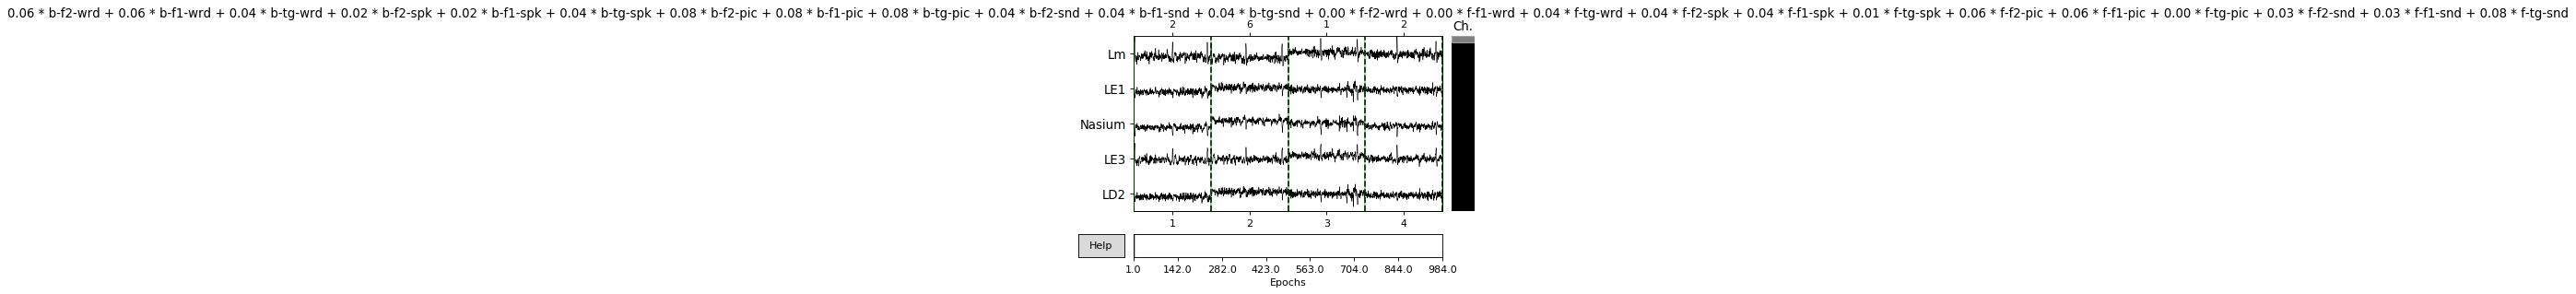

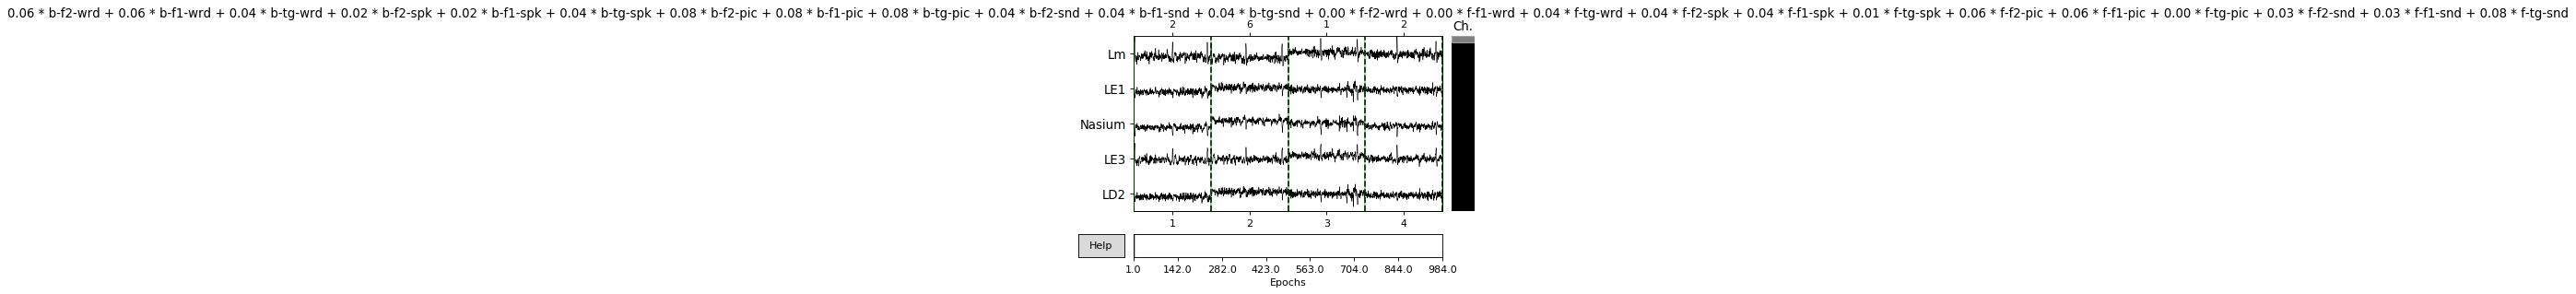

In [481]:
epoch.plot(n_channels=5,n_epochs=4)

In [796]:
type(test)

mne.epochs.Epochs

In [797]:
test.events

array([[  7064,      0,      2],
       [  7314,      0,      6],
       [  7564,      0,      1],
       ...,
       [474286,      0,     23],
       [474536,      0,     18],
       [474787,      0,     22]])

In [802]:
test4 = epoch.copy()
test5 = epoch.copy()
test6=epoch.copy()

In [800]:


visualStimCodes = ["VVLL","VVLN","VVNL","VVNN"]
audioStimCodes = ["AALL","AALN","AANL","AANN"]

def find_stim_combo(epochObj,visualStimCombo,audioStimCombo):
    events = epochObj.events
    numOfEvents = epoch.events.shape[0]
    events_new = []
    combo = []
    
    for i in range(0,numOfEvents,3):
        temp = []
        #print('three')
        for h in range(i,i+3):
            #print(events[h][-1])
            combo.append(events[h])
            
        combo_tuple = (combo[0][-1],combo[1][-1],combo[2][-1])   
        #print(combo_tuple)
        for k in visualStimCodes:
            if k == stim_combinations[combo_tuple]:
                #print("found visual")
                combo[0][-1] = 100
                combo[1][-1] = 100
                combo[2][-1] = 100
                temp.append(combo[0])
                temp.append(combo[1])
                temp.append(combo[2])
        
        for j in audioStimCodes:
            if j == stim_combinations[combo_tuple]:
                #print("found audio")
                combo[0][-1] = 200
                combo[1][-1] = 200
                combo[2][-1] = 200
                temp.append(combo[0])
                temp.append(combo[1])
                temp.append(combo[2])        
        
        for p in temp:
            events_new.append(p)
        combo = []
    return events_new
    
    

In [803]:
find_stim_combo(test4,["VVLL","VVLN","VVNL","VVNN"],["AALL","AALN","AANL","AANN"])

[array([34867,     0,   100]),
 array([35117,     0,   100]),
 array([35367,     0,   100]),
 array([35928,     0,   100]),
 array([36170,     0,   100]),
 array([36412,     0,   100]),
 array([36964,     0,   100]),
 array([37223,     0,   100]),
 array([37465,     0,   100]),
 array([38026,     0,   100]),
 array([38276,     0,   100]),
 array([38535,     0,   100]),
 array([39088,     0,   100]),
 array([39347,     0,   100]),
 array([39614,     0,   100]),
 array([40175,     0,   100]),
 array([40443,     0,   100]),
 array([40685,     0,   100]),
 array([41237,     0,   100]),
 array([41522,     0,   100]),
 array([41764,     0,   100]),
 array([42316,     0,   100]),
 array([42575,     0,   100]),
 array([42834,     0,   100]),
 array([43386,     0,   100]),
 array([43663,     0,   100]),
 array([43896,     0,   100]),
 array([44457,     0,   100]),
 array([44698,     0,   100]),
 array([44966,     0,   100]),
 array([45527,     0,   100]),
 array([45803,     0,   100]),
 array([

In [804]:
twoEventEpoch = test4[(test4.events[:,-1]==100) | (test4.events[:,-1]==200)].copy()

In [805]:
twoEventEpoch.events

array([[ 34867,      0,    100],
       [ 35117,      0,    100],
       [ 35367,      0,    100],
       ...,
       [474286,      0,    200],
       [474536,      0,    200],
       [474787,      0,    200]])

In [806]:
twoEventEpoch.get_data().shape

(744, 129, 500)

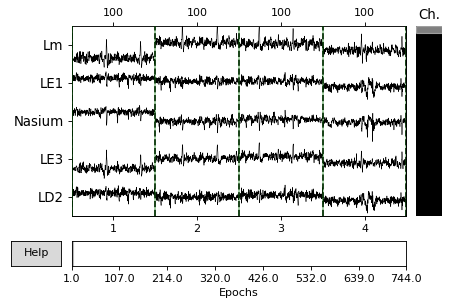

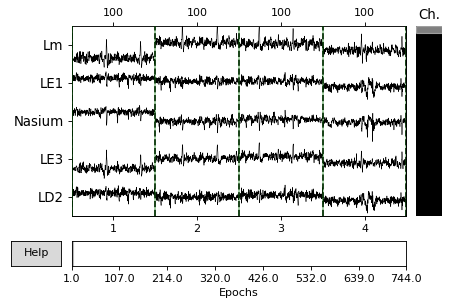

In [807]:
twoEventEpoch.plot(n_channels=5,n_epochs=4)

In [808]:
copyEpoch = twoEventEpoch.copy()

In [482]:
#Start of classification task with LogReg
"""
Store epoch data in variable and store epoch events in variable
print shape of both variables to check for consistency
"""
features = twoEventEpoch.get_data()
target = twoEventEpoch.events[:,-1]

print("shape of data",features.shape)

print("shape of target array",target.shape)

shape of data (744, 129, 500)
shape of target array (744,)


In [485]:
"""
pipeling for converting data from 3D to 2D using vectorizer and
LogisticRegression for classification 
"""

clf = make_pipeline(Vectorizer(),StandardScaler(),LogisticRegression())

cv = StratifiedKFold(n_splits=10,shuffle=True)
score = []
for train,test in cv.split(features,target):
    X_train = features[train]; y_train = target[train] 
    X_test = features[test];   y_test = target[test]

    clf.fit(X_train,y_train)
    score.append(clf.score(X_test,y_test))

In [695]:
print("mean classification score", np.round(np.mean(score),5))

mean classification score 0.5564


In [504]:
"""
get the coeficients after fitting clf to training sets
"""
from mne.decoding import get_coef
coefficients= get_coef(clf,'coef_')
print(coefficients.shape)

(1, 64500)


In [505]:
"""Shape coeficients data to 129 by 500"""
hold = []
for h in range(0,64499,500):
    temp = []
    for i in range(h,h+500):
        temp.append(coefficients[0][i])
    hold.append(temp)     
npHold = np.array(hold)
npHold.shape

(129, 500)

In [541]:
np.mean(npHold[0])

4.151205659096266e-05

In [565]:
channels = twoEventEpoch.ch_names
arr2 = []
for i in range(0,129):
    arr2.append( np.mean(npHold[i]))
    #print(channels[i], ' mean coef= ', np.round(np.mean(npHold[i]),7))
    


In [575]:
np.std(arr)  

0.002011440483375859

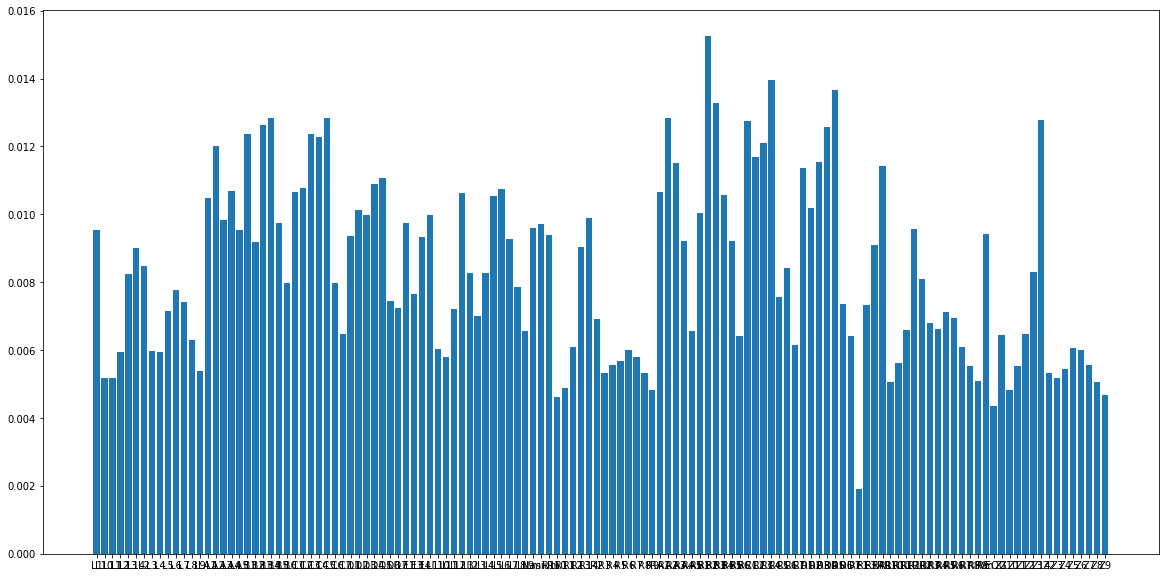

0.015252453030112077

In [713]:
arr3 = []
for k in range(0,128):
    arr3.append(np.std(npHold[k]))
    #print(channels[k], ' mean coef= ', np.round(np.var(npHold[k]),7))
plt.figure(figsize=(20,10))    
plt.bar(channels[0:-1],arr3)  
plt.show()  

np.max(arr3)

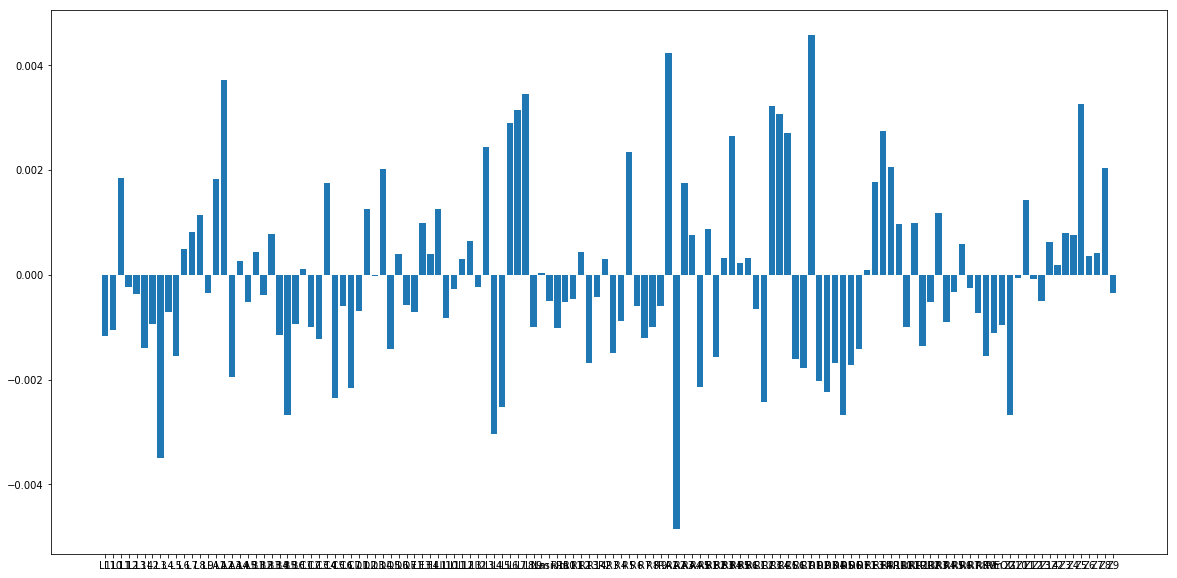

['Lm',
 'LE1',
 'Nasium',
 'LE3',
 'LD2',
 'LD5',
 'LC3',
 'LC6',
 'LB1',
 'LB4',
 'LA2',
 'LA5',
 'LL1',
 'LL4',
 'LL7',
 'LL10',
 'LL13',
 'L3',
 'L6',
 'L9',
 'L12',
 'Z1',
 'Z4',
 'Z7',
 'Z10',
 'Z13',
 'R3',
 'R6',
 'R9',
 'R12',
 'RR1',
 'RR4',
 'RR7',
 'RR10',
 'RR13',
 'RA2',
 'RA5',
 'RB1',
 'RB4',
 'RC3',
 'RC6',
 'RD2',
 'RD5',
 'RE1',
 'VEOG',
 'RE3',
 'Rm',
 'RE4',
 'RD1',
 'RD3',
 'RD4',
 'RD6',
 'RD7',
 'RC1',
 'RC2',
 'RC4',
 'RC5',
 'RC7',
 'RB2',
 'RB3',
 'RB5',
 'RB6',
 'RA1',
 'RA3',
 'RA4',
 'RR2',
 'RR3',
 'RR5',
 'RR6',
 'RR8',
 'RR9',
 'RR11',
 'RR12',
 'R1',
 'R2',
 'R4',
 'R5',
 'R7',
 'R8',
 'R10',
 'R11',
 'R13',
 'R14',
 'Z2',
 'Z3',
 'Z5',
 'Z6',
 'Z8',
 'Z9',
 'Z11',
 'Z12',
 'Z14',
 'L1',
 'L2',
 'L4',
 'L5',
 'L7',
 'L8',
 'L10',
 'L11',
 'L13',
 'L14',
 'LL2',
 'LL3',
 'LL5',
 'LL6',
 'LL8',
 'LL9',
 'LL11',
 'LL12',
 'LA1',
 'LA3',
 'LA4',
 'LB2',
 'LB3',
 'LB5',
 'LB6',
 'LC1',
 'LC2',
 'LC4',
 'LC5',
 'LC7',
 'LD1',
 'LD3',
 'LD4',
 'LD6',
 'LD7',
 

In [700]:
arr4 = []
for k in range(0,128):
    arr4.append(np.mean(npHold[k]))
    #print(channels[k], ' mean coef= ', np.round(np.var(npHold[k]),7))
plt.figure(figsize=(20,10))    
plt.bar(channels[0:-1],arr4)  
plt.show()    



In [701]:
min = np.min(arr4)
max = np.max(arr4)

print("max", round(max,5),"channel: ",arr.index(max),channels[arr.index(max)])
print("min", round(min,5),"channel: ",arr.index(min),channels[arr.index(min)])

max 0.00458 channel:  48 RD1
min -0.00485 channel:  35 RA2


,channel,variance,skew,kurtosis
Lm,0.0,0.000092,-0.053637,0.380203
LE1,1.0,0.000095,-0.124793,0.201870
Nasium,2.0,0.000095,-0.186555,0.358797
LE3,3.0,0.000059,0.020393,0.621899
LD2,4.0,0.000103,0.104408,0.410411
LD5,5.0,0.000123,-0.050712,1.169729
LC3,6.0,0.000153,-0.106482,0.655726
LC6,7.0,0.000064,0.053569,1.156822
LB1,8.0,0.000153,-0.227372,0.023795
LB4,9.0,0.000165,0.013557,-0.113540


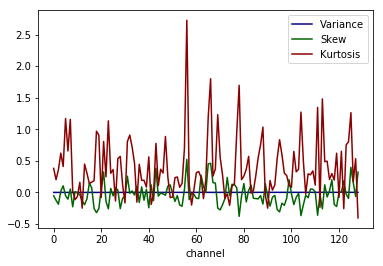

In [714]:
import scipy
import pandas as pd
#Simplify coef data by reducing 180 columns to 3
array1 = []
for i in range(0,129):
    store = []
    var1 = np.var(npHold[i])
    skew1 = scipy.stats.skew(npHold[i])
    kurtosis1 = scipy.stats.kurtosis(npHold[i])
    store.append(i)
    store.append(var1)
    store.append(skew1)
    store.append(kurtosis1)
    array1.append(store)

w1 = np.array(array1)   
dfff = pd.DataFrame(w1)  
dfff.index = channels
dfff.columns=['channel','variance','skew','kurtosis']
dfff

#plot the matrix
dfff.columns = ['channel','variance','skew','kurtosis']
ax = dfff.plot.line(x='channel',y='variance',color='DarkBlue',label='Variance')
dfff.plot.line(x='channel',y='skew',color='DarkGreen',label="Skew",ax=ax)
dfff.plot.line(x='channel',y='kurtosis',color="DarkRed",label="Kurtosis",ax=ax)



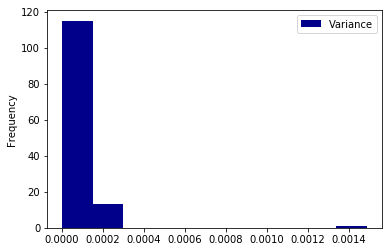

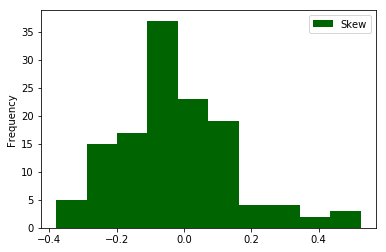

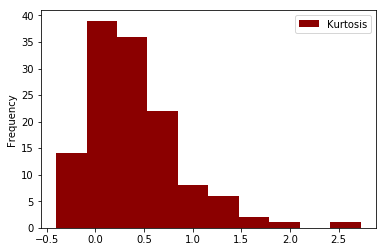

In [694]:
dfff.plot.hist(y='variance',color='DarkBlue',label='Variance')
dfff.plot.hist(y='skew',color='DarkGreen',label="Skew")
dfff.plot.hist(y='kurtosis',color="DarkRed",label="Kurtosis")

In [506]:
"""View Coeficients data in dataframe"""
import pandas as pd
df = pd.DataFrame(npHold)
df

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,0.000000,-0.008339,-0.004668,0.005875,0.025590,0.021077,0.010483,0.000508,0.002151,-0.001636,...,0.026203,0.000049,-0.015905,-0.000232,-0.009887,-9.193269e-03,0.001232,0.007000,0.006597,0.000559
1,0.000000,0.006026,-0.003083,-0.012815,0.001560,0.021308,0.000750,-0.014393,-0.022992,-0.020236,...,-0.006836,-0.012053,-0.002441,0.011461,-0.002846,4.868517e-03,0.011850,-0.000877,0.014469,0.019964
2,0.000000,0.016705,-0.003959,-0.009500,0.002190,-0.006402,-0.004138,-0.010669,-0.023654,-0.017842,...,0.004566,0.001036,0.010891,0.011073,0.003544,2.307032e-02,0.013542,-0.010378,0.004335,0.016747
3,0.000000,0.005767,0.002345,0.003484,0.019380,0.027610,0.008263,-0.003174,-0.002222,-0.009693,...,0.021777,0.001450,-0.002413,0.010489,-0.004587,-1.161885e-03,0.007711,0.007551,0.003665,0.000109
4,0.000000,-0.004108,0.004596,-0.002489,0.024186,0.027070,-0.001500,-0.013636,-0.021574,-0.008131,...,-0.016911,-0.001672,0.000414,0.008653,0.002205,6.129293e-03,0.008130,0.003567,0.019639,0.011418
5,0.000000,-0.024142,0.006195,0.001230,0.033045,0.044389,-0.004653,-0.022590,-0.006017,-0.008446,...,0.004301,-0.012670,-0.001840,-0.011888,0.008174,1.231545e-02,-0.008330,-0.008672,0.019844,0.016623
6,0.000000,-0.031317,0.016472,-0.014498,-0.002627,0.038595,-0.001969,0.001843,0.000362,-0.013810,...,0.001533,-0.011523,-0.018713,-0.003292,-0.012360,1.421209e-03,0.015559,0.002989,0.021602,0.008558
7,0.000000,0.034011,0.005297,-0.002650,0.000579,0.002234,0.012199,0.014519,-0.000757,-0.000423,...,0.023777,0.009245,-0.009860,0.018483,-0.000665,-1.368449e-03,0.007864,-0.002686,-0.014945,-0.013748
8,0.000000,-0.002565,0.014968,-0.006092,0.016531,0.001919,-0.006605,-0.006719,-0.035311,0.018968,...,-0.005477,0.018854,0.002808,-0.016862,-0.006702,-5.223865e-03,0.004762,-0.004387,0.008857,0.001596
9,0.000000,0.014383,0.001945,-0.007386,-0.018947,-0.015202,0.002697,0.000239,0.002134,0.005261,...,0.012350,-0.018307,-0.010905,-0.008764,-0.014754,2.681184e-02,0.009299,-0.003221,0.004050,0.009463


AttributeError: 'numpy.ndarray' object has no attribute 'events'

In [809]:
from scipy.stats import skew, kurtosis
import pandas as pd
def get_mean_band(data):
    final_variances = []
    for d in data:
    #     print (data.shape)
        variances = []
        skewnesses = []
        kurtosises = []
        stats = []
        for channel in d:
    #         print(channel.shape)
            var = channel.var()
            variances.append(var)
            
            skewness = skew(channel, axis=0)
#             print(skewness)

            skewnesses.append(skewness)
#             print(skewness)
            kurt = kurtosis(channel)
            kurtosises.append(kurt)
#         print(skewnesses)
#         mean_skew = np.mean(skewnesses)
#         stats.append(mean_skew)
#         stats.append(np.mean(variances))
        final_variances.append([variances, skewnesses, kurtosises])
    
    return np.array(final_variances)

In [810]:
test6 = twoEventEpoch.copy()

In [821]:
ReducePointsData = get_mean_band(test6.get_data())

In [823]:
ReducePointsData.shape

(744, 3, 129)

In [ ]:
"""
pipeling for converting data from 3D to 2D using vectorizer and
LogisticRegression for classification 
"""

clf = make_pipeline(Vectorizer(),StandardScaler(),LogisticRegression())

cv = StratifiedKFold(n_splits=10,shuffle=True)
score = []
for train,test in cv.split(features,target):
    X_train = features[train]; y_train = target[train] 
    X_test = features[test];   y_test = target[test]

    clf.fit(X_train,y_train)
    score.append(clf.score(X_test,y_test))

In [498]:
"""
#Use PCA
features2 = twoEventEpoch.get_data()
target2 = twoEventEpoch.events[:,-1]

Vectorizer().fit_transform(features2)


#init pca and fit to data
pca = UnsupervisedSpatialFilter(PCA(), average=False)
pca_data = pca.fit_transform(features2)
"""

In [502]:
"""
comp_variance = np.cumsum(pca.estimator.explained_variance_ratio_)
plt.plot(comp_variance, linewidth = 4.0, color = 'g')
plt.xlabel('Number of Components', fontsize = 25)
plt.ylabel('Cumulative Variance', fontsize = 25);
plt.xticks(fontsize = 25);
plt.yticks(fontsize = 25);
"""

"\ncomp_variance = np.cumsum(pca.estimator.explained_variance_ratio_)\nplt.plot(comp_variance, linewidth = 4.0, color = 'g')\nplt.xlabel('Number of Components', fontsize = 25)\nplt.ylabel('Cumulative Variance', fontsize = 25);\nplt.xticks(fontsize = 25);\nplt.yticks(fontsize = 25);\n"

In [503]:
#n_components = np.argwhere(comp_variance > .90)[0]
#print(n_components)